### Recipe

In [88]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import dill


def circuit(qubits, amps):
    for amp in amps:
        c = [*[('X', q) for i, q in enumerate(qubits)],
             ('Barrier', tuple(qubits)),
             *[(('Measure', i), q) for i, q in enumerate(qubits)]
             ]
        yield c


class Recipe(object):
    def __init__(self, scanname: str = '', shots: int = 1024, signal: str = 'iq_avg',
                 align_right: bool = False, waveform_length: float = 98e-6):
        """初始化任务描述

        Args:
            scanname (str, optional): 实验名称, 如 S21. Defaults to ''.
            shots (int, optional): 触发次数, 1024的整数倍. Defaults to 1024.
            signal (str, optional): 采集信号. Defaults to 'iq_avg'.
            align_right (bool, optional): 波形是否右对齐. Defaults to False.
            waveform_length (float, optional): 波形长度. Defaults to 98e-6.
        """
        self.scanname = scanname
        self.shots = shots
        self.signal = signal
        self.align_right = align_right
        self.waveform_length = waveform_length

        self.circuits: list[list] = []  # qlisp线路

        self.filename: str = 'test'  # 数据存储文件名, 位于桌面/home/dat文件夹下
        self.priority: int = 0  # 任务排队用, 越小优先级越高
        self.rules: list[str] = []  # 变量依赖关系列表, 详见bind方法
        self.loops: dict[str, list] = {}  # 自定义变量列表, 详见sweep方法

    def bind(self, path: str, value=None, variable: str = ''):
        """变量依赖关系列表

        Args:
            path (str): 变量在cfg表中的完整路径, 如gate.R.Q1.params.amp
            value (Any, optional): 变量的值. Defaults to None.
            variable (str, optional): 在loops中自定义的变量引用, 如`freq.Q0`. Defaults to ''.

        Raises:
            ValueError: _description_
            ValueError: _description_
        
        Examples: `self.rules`
            >>> self.bind('gate.R.Q0.params.frequency', variable='freq.Q0')
            >>> self.bind('gate.R.Q1.params.amp', value=0.1)
            ['<gate.R.Q0.params.frequency>=<freq.Q0>', '<gate.R.Q1.params.amp>=0.1']
        """
        if value:
            dep = f'<{path}>={value}'
        elif variable and isinstance(variable, str):
            if variable.split('.')[0] in self.loops:
                dep = f'<{path}>=<{variable}>'
            else:
                raise ValueError('variable not found in loops')
        else:
            raise ValueError('illegal assignment!')

        if dep not in self.rules:
            self.rules.append(dep)

    def sweep(self, group: str, target: str, value: np.array):
        """增加变量target到组group中

        Args:
            group (str): 变量组, 如对多个比特同时变频率扫描. 每个group对应一层循环, 多个group对应多层嵌套循环.
            target (str): 变量对应的标识符号, 任意即可.
            value (np.array): 变量对应的取值范围.

        Examples: `self.loops`
            >>> self.sweep('freq', 'Q0', array([2e6, 1e6,  0. ,  1e6,  2e6]))
            >>> self.sweep('freq', 'Q1', array([-3e6, -1.5e6,  0. ,  1.5e6,  3e6]))
            >>> self.sweep('amps', 'Q0', array([-0.2, -0.1,  0. ,  0.1,  0.2]))
            >>> self.sweep('amps', 'Q1', array([-0.24, -0.12,  0. ,  0.12,  0.24]))
            {'freq':[('Q0',array([2e6, 1e6,  0. ,  1e6,  2e6]), 'au')), ('Q1',array([-3e6, -1.5e6,  0. ,  1.5e6,  3e6]), 'au'))],
             'amps':[('Q0',array([-0.2, -0.1,  0. ,  0.1,  0.2]), 'au')), ('Q1',array([-0.24, -0.12,  0. ,  0.12,  0.24]), 'au'))]
            }
        """
        self.loops.setdefault(group, [])
        var = (target, value, 'au')

        if var not in self.loops[group]:
            self.loops[group].append(var)

    def dumps(self, filepath: Path, localhost: bool = True):
        """将线路写入文件

        Args:
            filepath (Path): 线路待写入的文件路径

        Raises:
            TypeError: 线路由StepStatus得到

        Returns:
            list: 线路中的比特列表
        """
        qubits = []
        circuits = []
        with open(filepath, 'w', encoding='utf-8') as f:
            for i, cc in enumerate(tqdm(self.circuits(), desc='CircuitExpansion')):
                if localhost:
                    f.writelines(str(dill.dumps(cc))+'\n')
                else:
                    circuits.append(cc)

                if i == 0:
                    # 获取线路中读取比特列表
                    for ops in cc:
                        if isinstance(ops[0], tuple) and ops[0][0] == 'Measure':
                            qubits.append((ops[0][1], ops[1]))
        return qubits, circuits

    def export(self):
        return {'metainfo': {'name': f'{self.filename}:/{self.scanname}',
                             'priority': self.priority,
                             'other': {'shots': self.shots,
                                       'signal': self.signal,
                                       'align_right': self.align_right,
                                       'waveform_length': self.waveform_length}
                             },
                'taskinfo': {'STEP': {'main': ['WRITE', tuple(self.loops)],
                                      'trig': ['WRITE', 'trig'],
                                      'read': ['READ', 'read'],
                                      },
                             'CIRQ': self.circuits,
                             'RULE': self.rules,
                             'LOOP': self.loops
                             },
                }

In [89]:
rcp = Recipe()

In [90]:
help(rcp.bind)

Help on method bind in module __main__:

bind(path: str, value=None, variable: str = '') method of __main__.Recipe instance
    变量依赖关系列表

    Args:
        path (str): 变量在cfg表中的完整路径, 如gate.R.Q1.params.amp
        value (Any, optional): 变量的值. Defaults to None.
        variable (str, optional): 在loops中自定义的变量引用, 如`freq.Q0`. Defaults to ''.

    Raises:
        ValueError: _description_
        ValueError: _description_

    Examples: `self.rules`
        >>> self.bind('gate.R.Q0.params.frequency', variable='freq.Q0')
        >>> self.bind('gate.R.Q1.params.amp', value=0.1)
        ['<gate.R.Q0.params.frequency>=<freq.Q0>', '<gate.R.Q1.params.amp>=0.1']



In [91]:
rcp.sweep('f','q',[1,2,3])
rcp.loops

{'f': [('q', [1, 2, 3], 'au')]}

In [92]:
rcp.bind('a.b.c',value=1234)
rcp.bind('c.d.e',variable='f.q')
rcp.export()

{'metainfo': {'name': 'test:/',
  'priority': 0,
  'other': {'shots': 1024,
   'signal': 'iq_avg',
   'align_right': False,
   'waveform_length': 9.8e-05}},
 'taskinfo': {'STEP': {'main': ['WRITE', ('f',)],
   'trig': ['WRITE', 'trig'],
   'read': ['READ', 'read']},
  'CIRQ': [],
  'RULE': ['<a.b.c>=1234', '<c.d.e>=<f.q>'],
  'LOOP': {'f': [('q', [1, 2, 3], 'au')]}}}

### qiskit

In [13]:
from qiskit import QuantumCircuit, qasm2

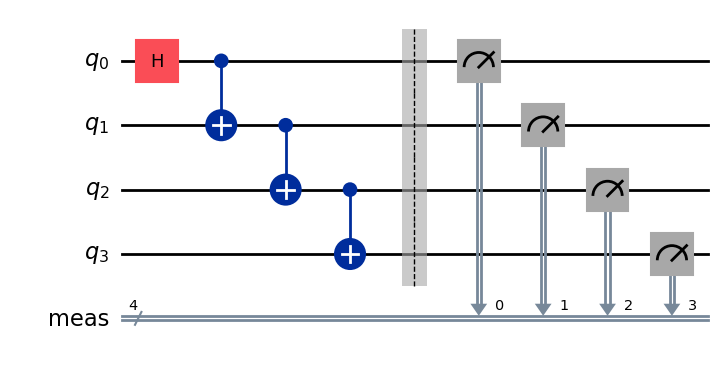

In [18]:
n =4
qc = QuantumCircuit(n)
qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)
qc.measure_all()
qc.draw('mpl')

In [19]:
print(qasm2.dumps(qc))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
creg meas[4];
h q[0];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
barrier q[0],q[1],q[2],q[3];
measure q[0] -> meas[0];
measure q[1] -> meas[1];
measure q[2] -> meas[2];
measure q[3] -> meas[3];


### waveform

In [1]:
circuit = [
    ('H', 'Q0'),
    ('Cnot', ('Q0', 'Q1')),
    ('Cnot', ('Q1', 'Q2')),
    ('Cnot', ('Q2', 'Q3')),
    ('Barrier', ('Q0', 'Q1', 'Q2', 'Q3')),
    (('Measure', 0), 'Q0'),
    (('Measure', 1), 'Q1'),
    (('Measure', 2), 'Q2'),
    (('Measure', 3), 'Q3'),
]

In [2]:
from pathlib import Path
import json

with open(Path.home()/'Desktop/home/cfg/144v424_WCL_MYJ_240307_previous.json', 'r') as f:
    cfg = json.loads(f.read())

for q in ['Q0', 'Q1', 'Q2','Q3']:
    cfg['gate']['Measure'][q]['default_type'] = 'default'

In [3]:
from quark.proxy import translate
cmds = translate(circuit,cfg)[1][0]

2024-11-01 14:41:13.729 | INFO     | quark.envelope.assembler:ccompile:188 - Step 0 compiled >>>>>>>>>>>>>


In [5]:
# cmds['main']['AWG_16_116_51.CH8.Waveform'][-1]['context']

In [17]:
# wf = cmds['main']['ZW_AD3.CH1.Waveform'][1]
# wf.start = 0
# wf.stop = 100e-6
# wf.sample_rate = 5e9
# import matplotlib.pyplot as plt

# plt.plot(wf.sample())

90.00000000000001 Q0
90.00000000000001 Q1
90.00000000000001 C0
90.00000000000001 Q2
90.00000000000001 C1
90.00000000000001 Q3
90.00000000000001 C2
90.00000000000001 M1


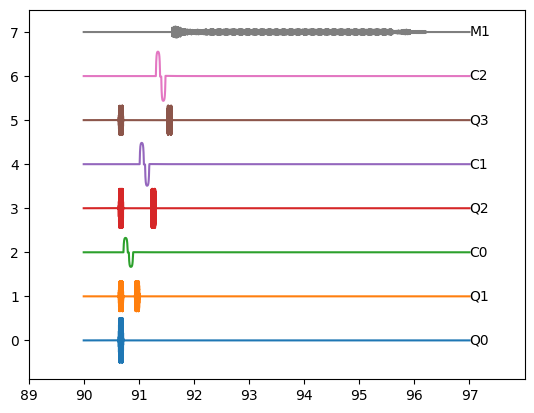

In [8]:
from quark.app import preview
from copy import deepcopy
samples = preview(deepcopy(cmds['main']),start=90e-6,stop=97e-6,offset=1,space=1)

In [10]:
import numpy as np
samples['Q0'].shape

(50000,)

In [3]:
e1 = np.array([1,4])
e2 = np.array([7,5])
m = np.array([[41,7],[-20,74]])

In [20]:
np.array([0,1])@m@e2

230

In [25]:
tt = np.array([[1,7],[4,5]])

In [30]:
iv = np.linalg.inv(tt)

In [34]:
(iv@m@tt).astype(int)

array([[69,  0],
       [ 0, 46]])

In [1]:
import site
site.getusersitepackages()

'C:\\Users\\NUC\\AppData\\Roaming\\Python\\Python312\\site-packages'